# Compare MLP, Transformer and CNN in Predicting Sine Values

In [1]:
import os
import math
import random
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn.functional as F
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import TensorDataset, DataLoader
from torch import nn, Tensor, Tuple
from torch.nn import TransformerEncoder, TransformerEncoderLayer
from torch.utils.data import dataset

### 1-1 Generate Data from Sin(wt)
f1(w, t) = sin(w*t)

In [2]:
# Constants

# Ranges of different frequencies, domain of w: [-M, M]
M = 5

# Function domain of t: [-N, N]
N = 20

# STEP_M: distance between adjacent frequencies [-M, -M + STEP_M, -M + 2STEP_M, ...]
STEP_M = 0.1

# Step_N: distance between adjacent sample points [-N, -N + STEP_N, -N + 2STEP_N, ...]
STEP_N = 0.05

# N/Step is the number of records (data points)
DATA_LEN = len(np.arange(-N, N, STEP_N))

# M/Step is the feature length
FEATURE_LEN = len(np.arange(-M, M, STEP_M))

# Number of history records used to predict the next record
WINDOW = 50


print("Number of data points: ", DATA_LEN)
print("Feature length: ", FEATURE_LEN)


Number of data points:  800
Feature length:  100


In [3]:
w = np.arange(-M, M, STEP_M)
t = np.arange(-N, N, STEP_N)
W, T = np.meshgrid(w, t)

F1_np = np.sin(W*T)
F1 = torch.Tensor(F1_np)
print("F1 data: ", F1.shape)

F1 data:  torch.Size([800, 100])


In [4]:
criterion = torch.nn.MSELoss()

# Last One Timestamp Loss
total_loss = 0.
for i in range(DATA_LEN-1):
    loss = criterion(F1[i], F1[i+1])
    total_loss = total_loss + loss.item()
total_loss = total_loss / (DATA_LEN-1)
print("Last timestamp Baseline Loss: ", total_loss)

# Last Two Timestamp Loss
for i in range(DATA_LEN-2):
    loss = criterion(2*F1[i+1]-F1[i], F1[i+2])
    total_loss = total_loss + loss.item()
total_loss = total_loss / (DATA_LEN-2)
print("Last two timestamps Linear Baseline Loss: ", total_loss)

Last timestamp Baseline Loss:  0.010386385246808261
Last two timestamps Linear Baseline Loss:  0.0004010039944418778


### 1-2 Plot Sine(wt) data

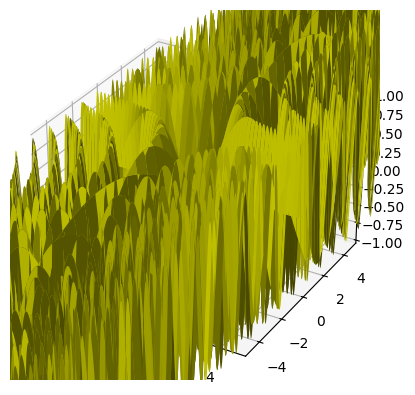

In [5]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

colortuple = ('y', 'b')
colors = np.empty(W.shape, dtype=str)
for y in range(len(t)):
    for x in range(len(w)):
        colors[y, x] = colortuple[(x + y) % len(colortuple)]

surf = ax.plot_surface(W, T, F1_np, facecolors=colors, linewidth=0)

ax.set_xlim(-5, 5)
ax.set_ylim(-5, 5)
ax.set_zlim(-1, 1)

plt.show()


### 2-1 Transformer Model

In [28]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [30]:
# Transformer Sin

class PositionalEncoding(torch.nn.Module):

    def __init__(self, d_model: int, dropout: float = 0.1, max_len: int = 5000):
        super().__init__()
        self.dropout = torch.nn.Dropout(p=dropout)

        position = torch.arange(max_len).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2) * (-math.log(10000.0) / d_model))
        pe = torch.zeros(max_len, 1, d_model)
        pe[:, 0, 0::2] = torch.sin(position * div_term)
        pe[:, 0, 1::2] = torch.cos(position * div_term)
        self.register_buffer('pe', pe)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        Arguments:
            x: Tensor, shape ``[seq_len, batch_size, feature_len]``
        """
        x = x + self.pe[:x.size(0)]
        return self.dropout(x)


class TransformerSin(torch.nn.Module):

    def __init__(self, d_model: int, d_hid: int, nhead : int = 4, nlayers: int = 4, dropout: float = 0.1):
        super().__init__()
        self.model_type = 'Transformer'
        self.pos_encoder = PositionalEncoding(d_model, dropout)
        encoder_layers = TransformerEncoderLayer(d_model, nhead, d_hid, dropout)
        self.transformer_encoder = TransformerEncoder(encoder_layers, nlayers)
        self.d_model = d_model
        self.linear = torch.nn.Linear(d_model, d_model)

        self.init_weights()

    def init_weights(self) -> None:
        initrange = 0.1
        self.linear.bias.data.zero_()
        self.linear.weight.data.uniform_(-initrange, initrange)

    def forward(self, src: torch.Tensor, src_mask: torch.Tensor = None) -> torch.Tensor:
        """
        Arguments:
            src: Tensor, shape ``[seq_len, batch_size, feature_len]``
            src_mask: Tensor, shape ``[seq_len, seq_len]``

        Returns:
            output Tensor of shape ``[seq_len, batch_size, dmodel]``
        """
        # src = self.pos_encoder(src)
        if src_mask is None:
            """Generate a square causal mask for the sequence. The masked positions are filled with float('-inf').
            Unmasked positions are filled with float(0.0).
            """
            src_mask = torch.nn.Transformer.generate_square_subsequent_mask(len(src))
        output = self.transformer_encoder(src, src_mask)
        output = self.linear(output)
        return output

transformer_sin = TransformerSin(FEATURE_LEN, FEATURE_LEN)
src = torch.rand(WINDOW, 1, FEATURE_LEN)
out = transformer_sin(src)
print("TransformerSin")
print("Input shape ", src.shape)
print("Output shape ", out.shape)
print("Number of parameters: ", count_parameters(transformer_sin))
print("Number of Inference Muliplication Operations: ", WINDOW * FEATURE_LEN * FEATURE_LEN*3*2*2 + 2*WINDOW*WINDOW*FEATURE_LEN)

TransformerSin
Input shape  torch.Size([50, 1, 100])
Output shape  torch.Size([50, 1, 100])
Number of parameters:  254100
Number of Inference Muliplication Operations:  6500000


### 2-2 Transformer Training and Evaluation

In [31]:
# Transformer Training
import time

TRANSFORMER_LR = 0.2
USE_LAST_ROW = True

criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(transformer_sin.parameters(), lr=TRANSFORMER_LR, momentum=0.9)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.95)
bptt = WINDOW

def get_batch(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Args:
        source: Tensor, shape ``[data_len, feature_len]``
        i: int

    Returns:
        tuple (data, target), in which
        data has shape ``[WINDOW, batch_size, feature_len]`` and
        target has shape ``[WINDOW, batch_size, feature_len]``
    """
    seq_len = min(bptt, len(source)-1-i)
    data = source[i:i+seq_len]
    target = source[i+1:i+1+seq_len].reshape(-1)
    return data, target


def get_data(source: Tensor, i: int) -> Tuple[Tensor, Tensor]:
    """
    Given a squence of n*d, generate the ith (data, target) pair 
    to be consumed by transformer assuming batch_size = 1
    
    Args:
        source: Tensor, shape ``[data_len, feature_len]``
        i: int
    
    Returns:
        tuple (data, target), in which
        data has shape ``[WINDOW, 1, feature_len]`` and
        target has shape ``[WINDOW, 1, feature_len]``
    """
    source_len = len(source)
    if i+WINDOW > source_len-1:
        return None, None

    data = source[i:i+WINDOW].reshape(WINDOW, 1, -1)
    target = source[i+1:i+WINDOW+1].reshape(WINDOW, 1, -1)
    return data, target
    

def train(model: torch.nn.Module, train_data: Tensor, train_indices) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 40
    start_time = time.time()

    for idx, i in enumerate(train_indices):
        data, target = get_data(train_data, i)
        if data is None:
            break
        output = model(data)
        if USE_LAST_ROW:
            loss = criterion(output[WINDOW-1, 0, :], target[WINDOW-1, 0, :])
        else:
            loss = criterion(output, target)
        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer.step()
        
        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            lr = scheduler.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {idx:5d}/{len(train_indices):5d} batches | '
                  f'lr {lr:02.5f} | ms/i {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.5f} | ppl {ppl:8.5f}')
            total_loss = 0
            start_time = time.time()

def evaluate(model: torch.nn.Module, eval_data: Tensor, val_indices) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i in val_indices:
            data, target = get_data(eval_data, i)
            output = model(data)
            if USE_LAST_ROW:
                loss = criterion(output[WINDOW-1, 0, :], target[WINDOW-1, 0, :])
            else:
                loss = criterion(output, target)
            total_loss += loss.item()
    return total_loss / len(val_indices)


In [32]:
import tempfile

best_val_loss = float('inf')
epochs = 40

def train_test_index_split(data, lengths):
    if len(lengths) != 3:
        return None
    data_len = len(data) - WINDOW
    train_num = int(data_len * lengths[0])
    val_num = int(data_len * lengths[1])
    test_num = int(data_len * lengths[2])
    indices = [*range(data_len)]
    random.shuffle(indices)
    train_indices = indices[0:train_num]
    val_indices = indices[train_num:train_num+val_num]
    test_indices = indices[train_num+val_num+test_num:]
    return train_indices, val_indices, test_indices
    

with tempfile.TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_model_params.pt")
    train_indices, val_indices, test_indices = train_test_index_split(F1, [0.6,0.2,0.2])
    
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train(transformer_sin, F1, train_indices)
        val_loss = evaluate(transformer_sin, F1, val_indices)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.5f} | valid ppl {val_ppl:8.5f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(transformer_sin.state_dict(), best_model_params_path)

        scheduler.step()

    transformer_sin.load_state_dict(torch.load(best_model_params_path))




| epoch   1 |    40/  450 batches | lr 0.20000 | ms/i  7.90 | loss 0.72745 | ppl  2.06980
| epoch   1 |    80/  450 batches | lr 0.20000 | ms/i  7.18 | loss 0.48453 | ppl  1.62342
| epoch   1 |   120/  450 batches | lr 0.20000 | ms/i  7.04 | loss 0.39128 | ppl  1.47888
| epoch   1 |   160/  450 batches | lr 0.20000 | ms/i  7.09 | loss 0.35714 | ppl  1.42924
| epoch   1 |   200/  450 batches | lr 0.20000 | ms/i  7.05 | loss 0.29570 | ppl  1.34407
| epoch   1 |   240/  450 batches | lr 0.20000 | ms/i  6.96 | loss 0.22691 | ppl  1.25471
| epoch   1 |   280/  450 batches | lr 0.20000 | ms/i  7.04 | loss 0.21935 | ppl  1.24527
| epoch   1 |   320/  450 batches | lr 0.20000 | ms/i  7.03 | loss 0.21193 | ppl  1.23607
| epoch   1 |   360/  450 batches | lr 0.20000 | ms/i  7.03 | loss 0.20161 | ppl  1.22337
| epoch   1 |   400/  450 batches | lr 0.20000 | ms/i  7.00 | loss 0.14993 | ppl  1.16176
| epoch   1 |   440/  450 batches | lr 0.20000 | ms/i  7.03 | loss 0.16118 | ppl  1.17489
----------

### 2-3 Transformer predict data autoregressively

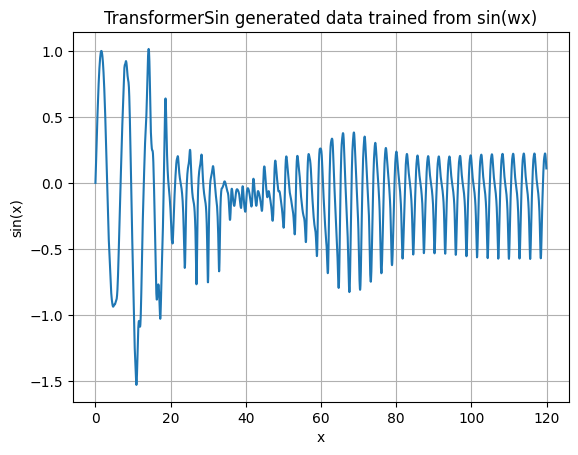

In [78]:
# Generate points using TransformerSin autoregressively and plot
NUM_POINTS = 2400
FREQUENCY = 60
x = np.arange(0, int(NUM_POINTS*STEP_N), STEP_N)
data_window, data_target = get_data(F1, DATA_LEN//2)


for i in range(len(x)-WINDOW):
    data_window_len = len(data_window)
    output = transformer_sin(data_window[data_window_len-WINDOW:data_window_len])
    data_window = torch.cat((data_window, output[WINDOW-1:WINDOW, :, :]),0)

y_tensor = data_window[:,0,FREQUENCY]

y = y_tensor.detach().numpy()

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='x', ylabel='sin(x)',
       title='TransformerSin generated data trained from sin(wx)')
ax.grid()

fig.savefig("test.png")
plt.show()

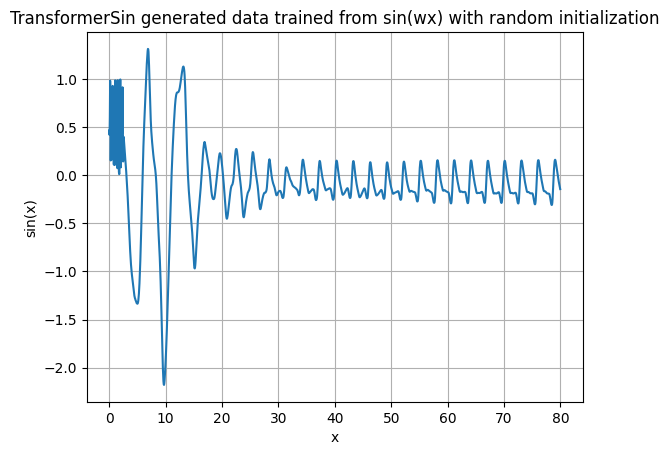

In [77]:
# Initialize the data with random input
NUM_POINTS = 1600
FREQUENCY = 60
x = np.arange(0, int(NUM_POINTS*STEP_N), STEP_N)
data_window = torch.rand(WINDOW,1,FEATURE_LEN)

for i in range(len(x)-WINDOW):
    data_window_len = len(data_window)
    output = transformer_sin(data_window[data_window_len-WINDOW:data_window_len])
    data_window = torch.cat((data_window, output[WINDOW-1:WINDOW, :, :]),0)

y_tensor = data_window[:,0,FREQUENCY]

y = y_tensor.detach().numpy()

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='x', ylabel='sin(x)',
       title='TransformerSin generated data trained from sin(wx) with random initialization')
ax.grid()

fig.savefig("test.png")
plt.show()

In [458]:
# Save model to file
save_model_params_path = os.path.join(os.getcwd(), "TSR5_model_params.pt")
torch.save(transformer_sin.state_dict(), save_model_params_path)

In [247]:
# Load model from file
load_model_params_path = os.path.join(os.getcwd(), "TSR5_model_params.pt")
transformer_sin.load_state_dict(torch.load(load_model_params_path))

<All keys matched successfully>

### 3-1 MLP Model

In [81]:
# Multilayer Perceptron

MLP_HIDDEN1 = 4*FEATURE_LEN

class MLP(torch.nn.Module):

  def __init__(self, dropout:float=0.1):
    super(MLP, self).__init__()
    self.fc1 = torch.nn.Linear(WINDOW * FEATURE_LEN, MLP_HIDDEN1)
    self.dropout = torch.nn.Dropout(p=dropout)
    self.fc2 = torch.nn.Linear(MLP_HIDDEN1, MLP_HIDDEN1)
    self.fc3 = torch.nn.Linear(MLP_HIDDEN1, FEATURE_LEN)


  def forward(self, x):
    x = self.fc1(x)
    x = F.elu(x)
    
    x = self.fc2(x)
    x = F.elu(x)
    
    x = self.fc3(x)
    return x

mlp_model = MLP()

src = torch.rand(FEATURE_LEN*WINDOW)
out = mlp_model(src)

print("Input shape: ", src.shape)
print("Output shape: ", out.shape)
print("MLP parameters: ", count_parameters(mlp_model))
print("MLP Inference Multiplication Operations: ", WINDOW * FEATURE_LEN * MLP_HIDDEN1 + FEATURE_LEN * MLP_HIDDEN1)

Input shape:  torch.Size([5000])
Output shape:  torch.Size([100])
MLP parameters:  2200900
MLP Inference Multiplication Operations:  2040000


### 3-2 MLP Training and Evaluation

In [51]:
MLP_LR = 0.01

criterion_mlp = torch.nn.MSELoss()
optimizer_mlp = torch.optim.SGD(mlp_model.parameters(), lr=MLP_LR, momentum=0.9)
scheduler_mlp = torch.optim.lr_scheduler.StepLR(optimizer_mlp, 1.0, gamma=0.95)

def get_data_mlp(source, i):
    """
    Given a squence of n*d, generate the ith (data, target) pair 
    to be consumed by MLP assuming batch_size = 1
    
    Args:
        source: Tensor, shape ``[data_len, feature_len]``
        i: int
    
    Returns:
        tuple (data, target), in which
        data has shape ``[WINDOW * feature_len]`` and
        target has shape ``[feature_len]``
    """
    source_len = len(source)
    if i+WINDOW >= source_len or i < 0:
        return None, None
    data = source[i:i+WINDOW].reshape(-1)
    target = source[i+WINDOW]
    
    return data, target


def train_mlp(model: torch.nn.Module, train_data: Tensor, train_indices) -> None:
    model.train()  # turn on train mode
    total_loss = 0.
    log_interval = 40
    start_time = time.time()

    for idx, i in enumerate(train_indices):
        data, target = get_data_mlp(train_data, i)
        if data is None:
            break
        output = model(data)
        loss = criterion_mlp(output, target)
        optimizer_mlp.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer_mlp.step()
        
        total_loss += loss.item()
        if idx % log_interval == 0 and idx > 0:
            lr = scheduler_mlp.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {idx:5d}/{len(train_indices):5d} batches | '
                  f'lr {lr:02.5f} | ms/i {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.5f} | ppl {ppl:8.5f}')
            total_loss = 0
            start_time = time.time() 


def evaluate_mlp(model: torch.nn.Module, eval_data: Tensor, val_indices) -> float:
    model.eval()  # turn on evaluation mode
    total_loss = 0.
    with torch.no_grad():
        for i in val_indices:
            data, target = get_data_mlp(eval_data, i)
            output = model(data)
            loss = criterion_mlp(output, target)
            total_loss += loss.item()
    return total_loss / len(val_indices)

In [52]:
import tempfile

best_val_loss = float('inf')
epochs = 40

with tempfile.TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_mlp_model_params.pt")
    train_indices, val_indices, test_indices = train_test_index_split(F1, [0.6,0.2,0.2])
    
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_mlp(mlp_model, F1, train_indices)
        val_loss = evaluate_mlp(mlp_model, F1, val_indices)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.5f} | valid ppl {val_ppl:8.5f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(mlp_model.state_dict(), best_model_params_path)

        scheduler_mlp.step()

    mlp_model.load_state_dict(torch.load(best_model_params_path))




| epoch   1 |    40/  450 batches | lr 0.01000 | ms/i  4.24 | loss 0.49949 | ppl  1.64788
| epoch   1 |    80/  450 batches | lr 0.01000 | ms/i  3.61 | loss 0.44571 | ppl  1.56159
| epoch   1 |   120/  450 batches | lr 0.01000 | ms/i  3.64 | loss 0.39619 | ppl  1.48615
| epoch   1 |   160/  450 batches | lr 0.01000 | ms/i  3.56 | loss 0.34563 | ppl  1.41288
| epoch   1 |   200/  450 batches | lr 0.01000 | ms/i  3.64 | loss 0.29597 | ppl  1.34444
| epoch   1 |   240/  450 batches | lr 0.01000 | ms/i  3.55 | loss 0.25187 | ppl  1.28643
| epoch   1 |   280/  450 batches | lr 0.01000 | ms/i  3.55 | loss 0.21811 | ppl  1.24372
| epoch   1 |   320/  450 batches | lr 0.01000 | ms/i  3.59 | loss 0.15943 | ppl  1.17284
| epoch   1 |   360/  450 batches | lr 0.01000 | ms/i  3.52 | loss 0.14789 | ppl  1.15938
| epoch   1 |   400/  450 batches | lr 0.01000 | ms/i  3.64 | loss 0.12171 | ppl  1.12943
| epoch   1 |   440/  450 batches | lr 0.01000 | ms/i  3.69 | loss 0.10284 | ppl  1.10831
----------

### 3-3 MLP predict data autoregressively

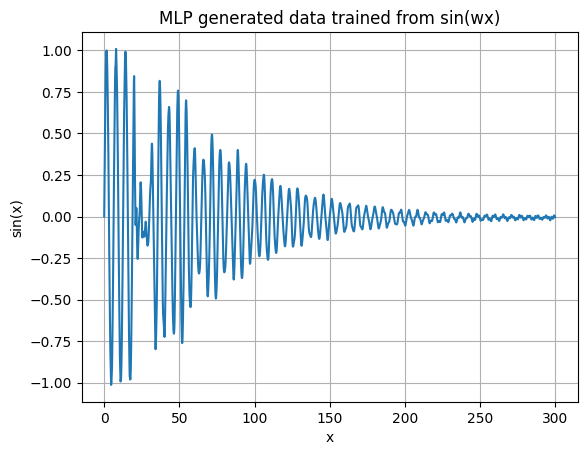

In [76]:
NUM_POINTS = 6000
FREQUENCY = 60
x = np.arange(0, int(NUM_POINTS*STEP_N), STEP_N)
data_window, data_target = get_data(F1, DATA_LEN//2)


for i in range(len(x)-WINDOW):
    data_window_len = len(data_window)
    output = mlp_model(data_window[data_window_len-WINDOW:data_window_len].reshape(-1))
    data_window = torch.cat((data_window, output.reshape(1,1,-1)),0)

y_tensor = data_window[:,0,FREQUENCY]

y = y_tensor.detach().numpy()

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='x', ylabel='sin(x)',
       title='MLP generated data trained from sin(wx)')
ax.grid()

fig.savefig("test.png")
plt.show()

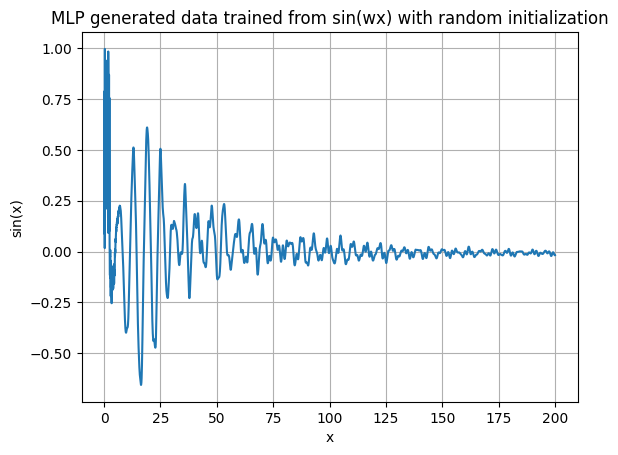

In [75]:
# Initialize with random data

NUM_POINTS = 4000
FREQUENCY = 60
x = np.arange(0, int(NUM_POINTS*STEP_N), STEP_N)
data_window = torch.rand(WINDOW,1,FEATURE_LEN)


for i in range(len(x)-WINDOW):
    data_window_len = len(data_window)
    output = mlp_model(data_window[data_window_len-WINDOW:data_window_len].reshape(-1))
    data_window = torch.cat((data_window, output.reshape(1,1,-1)),0)

y_tensor = data_window[:,0,FREQUENCY]

y = y_tensor.detach().numpy()

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='x', ylabel='sin(x)',
       title='MLP generated data trained from sin(wx) with random initialization')
ax.grid()

fig.savefig("test.png")
plt.show()

### 4-1 CNN Model

In [97]:
class CNN(torch.nn.Module):
  def __init__(self):
    super(CNN, self).__init__()
    self.pool = nn.MaxPool2d(2, 2)
    self.conv1 = nn.Conv2d(1, 32, 7)
    self.conv2 = nn.Conv2d(32, 64, 7)
    self.fc1 = torch.nn.Linear(64*20*8, 2*FEATURE_LEN)
    self.fc2 = torch.nn.Linear(2*FEATURE_LEN, FEATURE_LEN)

  def forward(self, x):
    x = self.conv1(x)
    x = self.pool(x)
    x = self.conv2(x)
    x = self.pool(x)
    x = torch.flatten(x)
    x = self.fc1(x)
    x = F.elu(x)
    x = self.fc2(x)
    return x

cnn_model = CNN()

src = torch.rand(1, WINDOW, FEATURE_LEN)
out = cnn_model(src)

print("Input shape: ", src.shape)
print("Output shape: ", out.shape)
print("CNN parameters: ", count_parameters(cnn_model))
print("CNN Inference Multiplication Operations: ", WINDOW*FEATURE_LEN*32*7*7 + 22*47*32*64*7*7 + 10240*200 + 200*100)

Input shape:  torch.Size([1, 50, 100])
Output shape:  torch.Size([100])
CNN parameters:  2170316
CNN Inference Multiplication Operations:  113671968


### 4-2 CNN Training and Evaluation

In [99]:
CNN_LR = 0.01
criterion_cnn = torch.nn.MSELoss()
optimizer_cnn = torch.optim.SGD(cnn_model.parameters(), lr=CNN_LR, momentum=0.9)
scheduler_cnn = torch.optim.lr_scheduler.StepLR(optimizer_cnn, 1.0, gamma=0.95)

def get_data_cnn(source, i):

    source_len = len(source)
    if i+WINDOW >= source_len or i < 0:
        return None, None
    data = source[i:i+WINDOW].reshape(1, WINDOW, FEATURE_LEN)
    target = source[i+WINDOW]
    
    return data, target


def train_cnn(model, train_data, train_indices):
    model.train()
    total_loss = 0.
    log_interval = 40
    start_time = time.time()

    for idx, i in enumerate(train_indices):
        data, target = get_data_cnn(train_data, i)
        if data == None:
            break

        output = model(data)
        loss = criterion_cnn(output, target)
        optimizer_cnn.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.5)
        optimizer_cnn.step()

        total_loss += loss.item()
        
        if idx % log_interval == 0 and idx > 0:
            lr = scheduler_cnn.get_last_lr()[0]
            ms_per_batch = (time.time() - start_time) * 1000 / log_interval
            cur_loss = total_loss / log_interval
            ppl = math.exp(cur_loss)
            print(f'| epoch {epoch:3d} | {idx:5d}/{len(train_indices):5d} batches | '
                  f'lr {lr:02.5f} | ms/i {ms_per_batch:5.2f} | '
                  f'loss {cur_loss:5.5f} | ppl {ppl:8.5f}')
            total_loss = 0
            start_time = time.time() 


def evaluate_cnn(model, eval_data, eval_indices):
    model.eval()
    total_loss = 0.

    with torch.no_grad():
        for idx, i in enumerate(eval_indices):
            data, target = get_data_cnn(eval_data, i)
            output = model(data)
            loss = criterion_cnn(output, target)
            total_loss += loss.item()

    return total_loss / len(eval_indices)
    

In [100]:
import tempfile

best_val_loss = float('inf')
epochs = 40

with tempfile.TemporaryDirectory() as tempdir:
    best_model_params_path = os.path.join(tempdir, "best_cnn_params.pt")
    train_indices, val_indices, test_indices = train_test_index_split(F1, [0.6,0.2,0.2])
    
    for epoch in range(1, epochs + 1):
        epoch_start_time = time.time()
        train_cnn(cnn_model, F1, train_indices)
        val_loss = evaluate_cnn(cnn_model, F1, val_indices)
        val_ppl = math.exp(val_loss)
        elapsed = time.time() - epoch_start_time
        print('-' * 89)
        print(f'| end of epoch {epoch:3d} | time: {elapsed:5.2f}s | '
            f'valid loss {val_loss:5.5f} | valid ppl {val_ppl:8.5f}')
        print('-' * 89)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(cnn_model.state_dict(), best_model_params_path)

        scheduler_cnn.step()

    cnn_model.load_state_dict(torch.load(best_model_params_path))


| epoch   1 |    40/  450 batches | lr 0.01000 | ms/i  6.31 | loss 0.50677 | ppl  1.65992
| epoch   1 |    80/  450 batches | lr 0.01000 | ms/i  5.53 | loss 0.45875 | ppl  1.58209
| epoch   1 |   120/  450 batches | lr 0.01000 | ms/i  5.53 | loss 0.44794 | ppl  1.56509
| epoch   1 |   160/  450 batches | lr 0.01000 | ms/i  5.61 | loss 0.40235 | ppl  1.49534
| epoch   1 |   200/  450 batches | lr 0.01000 | ms/i  5.50 | loss 0.36085 | ppl  1.43456
| epoch   1 |   240/  450 batches | lr 0.01000 | ms/i  5.52 | loss 0.29703 | ppl  1.34585
| epoch   1 |   280/  450 batches | lr 0.01000 | ms/i  5.52 | loss 0.26255 | ppl  1.30024
| epoch   1 |   320/  450 batches | lr 0.01000 | ms/i  5.57 | loss 0.24101 | ppl  1.27254
| epoch   1 |   360/  450 batches | lr 0.01000 | ms/i  5.55 | loss 0.22071 | ppl  1.24696
| epoch   1 |   400/  450 batches | lr 0.01000 | ms/i  5.60 | loss 0.21322 | ppl  1.23765
| epoch   1 |   440/  450 batches | lr 0.01000 | ms/i  5.45 | loss 0.17693 | ppl  1.19354
----------

### 4-3 CNN generate points autoregressively

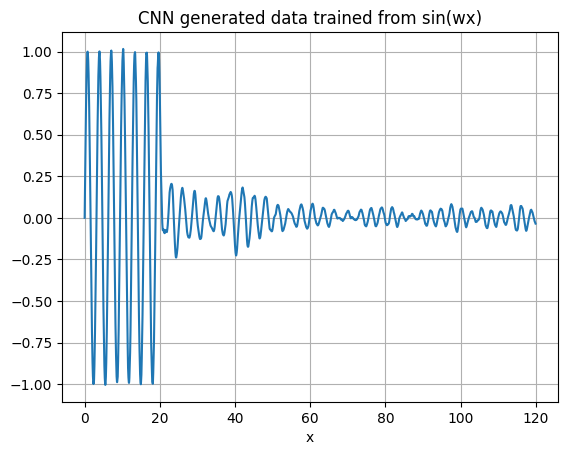

In [107]:
NUM_POINTS = 2400
FREQUENCY = 70
x = np.arange(0, int(NUM_POINTS*STEP_N), STEP_N)
data_window, data_target = get_data(F1, DATA_LEN//2)


for i in range(len(x)-WINDOW):
    data_window_len = len(data_window)
    output = cnn_model(data_window[data_window_len-WINDOW:data_window_len].reshape(1, WINDOW, FEATURE_LEN))
    data_window = torch.cat((data_window, output.reshape(1,1,-1)),0)

y_tensor = data_window[:,0,FREQUENCY]

y = y_tensor.detach().numpy()

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='x', ylabel='',
       title='CNN generated data trained from sin(wx)')
ax.grid()

fig.savefig("test.png")
plt.show()


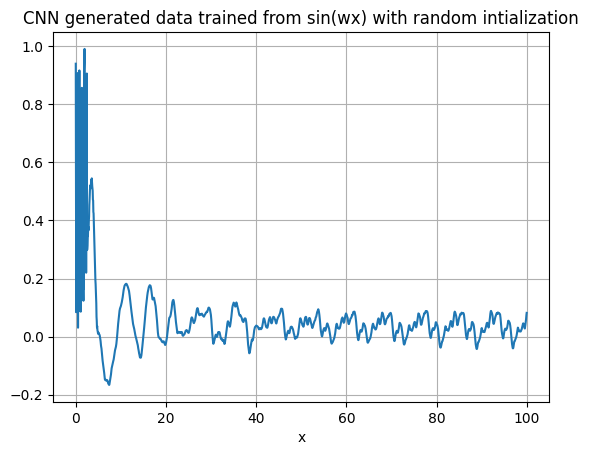

In [102]:
# Initialize with random data

NUM_POINTS = 2000
FREQUENCY = 60
x = np.arange(0, int(NUM_POINTS*STEP_N), STEP_N)
data_window = torch.rand(WINDOW,1,FEATURE_LEN)


for i in range(len(x)-WINDOW):
    data_window_len = len(data_window)
    output = cnn_model(data_window[data_window_len-WINDOW:data_window_len].reshape(1, WINDOW, FEATURE_LEN))
    data_window = torch.cat((data_window, output.reshape(1,1,-1)),0)

y_tensor = data_window[:,0,FREQUENCY]

y = y_tensor.detach().numpy()

fig, ax = plt.subplots()
ax.plot(x, y)

ax.set(xlabel='x', ylabel='',
       title='CNN generated data trained from sin(wx) with random intialization')
ax.grid()

fig.savefig("test.png")
plt.show()